In [1]:
#Imports
from os.path import dirname, join as pjoin
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import tensorflow as tf
# import keras
# from tqdm.auto import tqdm
import glob
# import imageio
import natsort
import cv2
from matplotlib import gridspec
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error
import psutil
from scipy.io import savemat

from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error
from skimage.util import view_as_windows
import mat73
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab

from IPython import display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv3D, Conv2D, MaxPooling1D, Conv1D, Input, \
    BatchNormalization, Conv2DTranspose, UpSampling2D, UpSampling1D, ZeroPadding1D, Lambda, LeakyReLU, Concatenate,ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1, l1_l2

tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# print(keras.__version__)
print(tf.__version__)

psutil.virtual_memory().percent

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6

2.5.0


12.1

In [2]:
def reset_keras(verbose=True):
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    tf.compat.v1.sess = tf.compat.v1.keras.backend.get_session()


    if verbose==True:
        print(gc.collect()) # if it's done something you should see a number being outputted
    else: 
        pass

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [3]:
cd C:\Users\Khaled\OneDrive - University of Glasgow\NLOS-Fusion\ML_datasets_metaldetection\05112021

C:\Users\Khaled\OneDrive - University of Glasgow\NLOS-Fusion\ML_datasets_metaldetection\05112021


In [30]:
#Load in and initialise arrays (SUPERSET)

start = time.process_time()



# filecode1 = '_05112021_KK_Knife_sceneA_r1.mat'

# filecode2 = '_05112021_KK_No_Knife_sceneA_r3.mat'

# filecode3 = '_05112021_KK_Knife_sceneA_r2.mat'

# filecode4 =  '_05112021_KK_No_Knife_sceneA_r4.mat'




filecode1 = '_05112021_KK_Knife_sceneB_r5.mat'

filecode2 = '_05112021_KK_NoKnife_sceneB_r7.mat'

filecode3 = '_05112021_KK_Knife_sceneB_r6.mat'

filecode4 =  '_05112021_KK_NoKnife_sceneB_r8.mat'



#RADAR
data_dict = mat73.loadmat(f'TIDCA_{filecode1}', use_attrdict=True)
rad_buffer_mat1 = data_dict['frames_picked'] # assuming a structure was saved in the .mat

data_dict = mat73.loadmat(f'TIDCA_{filecode2}', use_attrdict=True)
rad_buffer_mat2 = data_dict['frames_picked'] # assuming a structure was saved in the .mat

data_dict = mat73.loadmat(f'TIDCA_{filecode3}', use_attrdict=True)
rad_buffer_mat3 = data_dict['frames_picked'] # assuming a structure was saved in the .mat

data_dict = mat73.loadmat(f'TIDCA_{filecode4}', use_attrdict=True)
rad_buffer_mat4 = data_dict['frames_picked'] # assuming a structure was saved in the .mat




rad_buffer_mat = np.concatenate((rad_buffer_mat1[:,:,:,:,:,:],rad_buffer_mat2[:,:,:,:,:,:],rad_buffer_mat3[:,:,:,:,:,:],rad_buffer_mat4[:,:,:,:,:,:]),axis=5)


# Output


classif_buffer_mat1 = np.ones((1,1500)) 

classif_buffer_mat2 = np.zeros((1,1500))

classif_buffer_mat3 = np.ones((1,1500)) 

classif_buffer_mat4 =  np.zeros((1,1500))

classif_buffer_mat = np.concatenate((classif_buffer_mat1,classif_buffer_mat2,classif_buffer_mat3,classif_buffer_mat4),axis=1)



del data_dict
del rad_buffer_mat1,rad_buffer_mat2,rad_buffer_mat3,rad_buffer_mat4

classif_buffer = np.ascontiguousarray(classif_buffer_mat.T) #transpose to convert from (X,Y,Z) to (Z,X,Y)
rad_buffer = np.ascontiguousarray(rad_buffer_mat.T) #"   "   "   

del classif_buffer_mat
del rad_buffer_mat



classif = np.asarray(classif_buffer).astype('float16')
radar = np.asarray(rad_buffer).astype('float16')



del classif_buffer
del rad_buffer

print(classif.shape)
print(radar.shape)



# min_elapsed = (time.process_time() - start) 
# print('Finished!')
# print('Time taken: %d s'%min_elapsed)


(6000, 1)
(6000, 64, 3, 512, 2, 4)


In [5]:
# some functions to add more functionality

def normalize(data):    
    data = data-np.min(data)
    data = data/np.max(data)
    return data

def pre_process(radar,no_bg = True,fullbg=True,segment=False,range_lim = np.nan,rel_th=np.nan):
    # reshape some stuff
    radar = radar.transpose([0,5,2,1,3,4]) 
    # go to CRD
    rad_data_complex = radar[:,:,:,:,:,0]+1j*radar[:,:,:,:,:,1]
    crd_corr =  np.fft.fft2(rad_data_complex, axes=(- 2, - 1))
    print('in crd')
    # drop middle antenna with vertical offset
    crd_corr = crd_corr[:,:,[0,2],:,:]
    # reshape and stack CRD for each virtual antenna
    crd_corr = crd_corr.transpose([0,2,1,3,4])
    crd_corr_shape = crd_corr.shape
    crd_corr = crd_corr.reshape(crd_corr_shape[0],crd_corr_shape[1]*crd_corr_shape[2],crd_corr_shape[3],crd_corr_shape[4])
    if range_lim != np.nan:
        # limit range so multi-path not possible
        crd_corr = crd_corr[:,:,:,:range_lim]
    # getting the phase of each crd bin and aoa cube
    # phase_cube = np.angle(crd_corr)
    aoa_cube = np.abs(np.fft.fft(crd_corr,axis=1))
    print('in aoa_cube')
    # getting mean of ard across all antennas
    ard = np.mean(np.abs(crd_corr),axis=(1))
    ard = normalize(ard)
    aoa_cube = normalize(aoa_cube)
    # add axis to ard and stack
    ard_shape = ard.shape
    ard = ard.reshape((ard_shape[0],1,ard_shape[1],ard_shape[2]))
    ard_aoa_stack = np.append(aoa_cube,ard,axis=1)
    if rel_th != np.nan:
        # set stuff
        object_mask = ard > rel_th
        ard_aoa_stack = (ard_aoa_stack.T*object_mask.T).T
    if no_bg:
        print('removing bg')
        if fullbg:
            ard_aoa_stack = ard_aoa_stack-np.mean(ard_aoa_stack[:,:,:,:],axis=0) 
        else:
            movavg_fr = 20
            # get rid of da background
            for i in range(ard_aoa_stack.shape[0]-movavg_fr):
                ard_aoa_stack[i+movavg_fr,:,:,:] = ard_aoa_stack[i+movavg_fr,:,:,:]-np.mean(ard_aoa_stack[i:i+movavg_fr,:,:,:],axis=0) 
        # put everything below zero to zero, because bg subtraction
        ard_aoa_stack[ard_aoa_stack < 0 ] = 0
    # tranpose so conv across crd
    ard_aoa_stack = ard_aoa_stack.transpose([0,3,2,1])
    return ard_aoa_stack



In [31]:
# pre-process the data
ard_aoa_stack = pre_process(radar,range_lim=150,rel_th=0.01)

in crd
in aoa_cube
removing bg


In [32]:
# seperate into training and testing set
train_radar1 = ard_aoa_stack[0:3000-300]
train_radar2 = ard_aoa_stack[3000+300:]
train_radar = np.concatenate((train_radar1,train_radar2))
test_radar = ard_aoa_stack[3000-300:3000+300]
val_radar = test_radar.copy()

train_classif1 = classif[0:3000-300]
train_classif2 = classif[3000+300:]
train_classif = np.concatenate((train_classif1,train_classif2))
test_classif = classif[3000-300:3000+300]
val_classif = test_classif.copy()


# print(train_radar.shape)
# print(radar.shape)
print(train_classif.shape)
print(test_classif.shape)
print(train_radar.shape)
print(test_radar.shape)

(5400, 1)
(600, 1)
(5400, 150, 64, 9)
(600, 150, 64, 9)


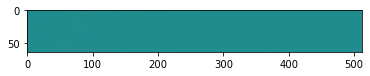

In [15]:
# check again ard plot
plt.figure(5)
plt.imshow(train_radar[56,:,:,0].astype('float32'))

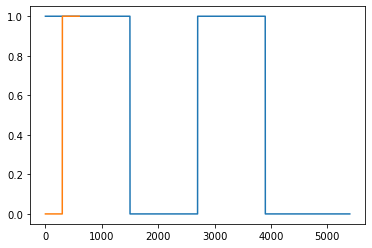

In [19]:
# check split

plt.plot(train_classif)
plt.plot(test_classif)

In [33]:
# Architecture
def METALDETEC(feats, kern_int_d, kern_reg, ksd, summary=False):


    inp_radar = Input(shape=(150,64,9,1)) # [1,2,4] streams of Radar histograms 

    ###################################################################################################################
            # CNN layer
    ###################################################################################################################
    conv1 = Conv3D(feats, ksd, activation='relu', padding='same', kernel_regularizer=kern_reg, kernel_initializer=kern_int_d)(inp_radar)

    flatt_feat = Flatten()(conv1)

    dense1 = Dense(1,activation='sigmoid')(flatt_feat)
    
    out =  tf.keras.layers.Reshape((1,))(dense1)

    # lamb1 = Lambda(custom_sigmoid)(out)
    
    model = tf.keras.Model(inputs=[inp_radar], outputs=out)
    if summary==True:
        model.summary()

    return model


def train_METALDETEC(train_inputs, train_labels, val_inputs, val_labels, epochs, feats, batch, kern_int_d, kern_reg, ksd, val):
    
    model = METALDETEC(feats, kern_int_d, kern_reg, ksd)
    adam = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
    model.compile(loss='bce',optimizer=adam, metrics=['accuracy'])

    #enable callbacks for validation
    if val==True:
      my_callbacks = [EarlyStopping(monitor='val_loss',
                                    patience=10)]
    #disable callbacks for training final model
    if val==False:
      my_callbacks = []
                        
    
    start=time.time()
    history = model.fit(train_inputs, train_labels, epochs=epochs, batch_size=batch, 
                        validation_data=(val_inputs, val_labels), verbose=1, 
                        callbacks=my_callbacks, shuffle= True)
    end=time.time()
     
    print('comp. time =',end-start)
    return model, history.history['loss'], history.history['val_loss']
    # return model, history.history['loss'], history.history['loss']
    
METALDETEC(feats=1, kern_int_d='he_normal', ksd=5, kern_reg=None, summary=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 64, 9, 1)]   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 150, 64, 9, 1)     126       
_________________________________________________________________
flatten_1 (Flatten)          (None, 86400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 86401     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1)                 0         
Total params: 86,527
Trainable params: 86,527
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Fit model with GPU
reset_keras(verbose=False)
model, train_hist, val_hist = train_METALDETEC(train_inputs = [train_radar],
                        train_labels = train_classif,
                        val_inputs = [val_radar],
                        val_labels = val_classif,
                        epochs=50,
                        feats=1,
                        batch=10,
                        kern_int_d='he_normal', # glorot_uniform
                        ksd=5,
                        kern_reg=None,
                        val=False)

Epoch 1/50
540/540 [==============================] - 5s 9ms/step - loss: 0.6919 - accuracy: 0.5804 - val_loss: 0.6919 - val_accuracy: 0.6100
Epoch 2/50
540/540 [==============================] - 5s 9ms/step - loss: 0.6859 - accuracy: 0.6559 - val_loss: 0.6908 - val_accuracy: 0.5933
Epoch 3/50
540/540 [==============================] - 5s 9ms/step - loss: 0.6784 - accuracy: 0.6228 - val_loss: 0.6894 - val_accuracy: 0.5700
Epoch 4/50
540/540 [==============================] - 4s 8ms/step - loss: 0.6710 - accuracy: 0.6219 - val_loss: 0.6885 - val_accuracy: 0.5767
Epoch 5/50
540/540 [==============================] - 4s 8ms/step - loss: 0.6641 - accuracy: 0.6426 - val_loss: 0.6865 - val_accuracy: 0.5850
Epoch 6/50
540/540 [==============================] - 4s 8ms/step - loss: 0.6569 - accuracy: 0.6391 - val_loss: 0.6840 - val_accuracy: 0.5783
Epoch 7/50
540/540 [==============================] - 5s 9ms/step - loss: 0.6506 - accuracy: 0.6448 - val_loss: 0.6837 - val_accuracy: 0.5600
Epoch 

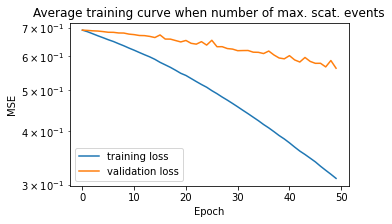

In [35]:
fig=plt.figure(figsize=(5,3))
plt.title('Average training curve when number of max. scat. events')
plt.plot(train_hist,label='training loss')
plt.plot(val_hist,label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()    
# plt.savefig(folder + '/' + f'training_progression_l1min_epoch_50_feat64__Rx1AB_Rx2AB.svg')
plt.show()


In [ ]:
# check performance
predictions = np.float64(model.predict([val_radar]))
np.mean((np.abs(predictions-val_classif)<0.3))

In [20]:
#Load in scnd background

start = time.process_time()



filecode1 = '_05112021_KK_Knife_sceneA_r1.mat'

filecode2 = '_05112021_KK_No_Knife_sceneA_r3.mat'

# filecode3 = '_05112021_KK_Knife_sceneA_r2.mat'

# filecode4 =  '_05112021_KK_No_Knife_sceneA_r4.mat'




# filecode1 = '_05112021_KK_Knife_sceneB_r5.mat'

# filecode2 = '_05112021_KK_NoKnife_sceneB_r7.mat'

# filecode3 = '_05112021_KK_Knife_sceneB_r6.mat'

# filecode4 =  '_05112021_KK_NoKnife_sceneB_r8.mat'



#RADAR
data_dict = mat73.loadmat(f'TIDCA_{filecode1}', use_attrdict=True)
rad_buffer_mat1 = data_dict['frames_picked'] # assuming a structure was saved in the .mat

data_dict = mat73.loadmat(f'TIDCA_{filecode2}', use_attrdict=True)
rad_buffer_mat2 = data_dict['frames_picked'] # assuming a structure was saved in the .mat





rad_buffer_mat = np.concatenate((rad_buffer_mat1[:,:,:,:,:,:],rad_buffer_mat2[:,:,:,:,:,:]),axis=5)


# Output


classif_buffer_mat1 = np.ones((1,1500)) 

classif_buffer_mat2 = np.zeros((1,1500))

classif_buffer_mat = np.concatenate((classif_buffer_mat1,classif_buffer_mat2),axis=1)



del data_dict
del rad_buffer_mat1,rad_buffer_mat2

classif_buffer = np.ascontiguousarray(classif_buffer_mat.T) #transpose to convert from (X,Y,Z) to (Z,X,Y)
rad_buffer = np.ascontiguousarray(rad_buffer_mat.T) #"   "   "   

del classif_buffer_mat
del rad_buffer_mat



classif_bg2 = np.asarray(classif_buffer).astype('float16')
radar_bg2 = np.asarray(rad_buffer).astype('float16')



del classif_buffer
del rad_buffer

print(classif.shape)
print(radar.shape)



# min_elapsed = (time.process_time() - start) 
# print('Finished!')
# print('Time taken: %d s'%min_elapsed)


(3000, 1)
(6000, 64, 3, 512, 2, 4)


In [37]:
# pre-process second background
ard_aoa_stackbg2 = pre_process(radar_bg2,range_lim=150,rel_th=0.10)

in crd
in aoa_cube
removing bg


In [41]:
# predict for new background

predictions = np.float64(model.predict([ard_aoa_stackbg2]))
np.mean((np.abs(predictions-classif_bg2)<0.3))

0.3303333333333333